# Imports

In [0]:
import zipfile
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import csv

# Prepare Google Drive (for persistent storage)

In [0]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Download data from Kaggle

In [0]:
# we need to use python 3 version of Kaggle!
# remove python 2 version with `pip uninstall kaggle`
! pip3 install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
# get <token> from https://www.kaggle.com/<user>/account, click "Create New API Token", open json file
# ! KAGGLE_USERNAME=<user> KAGGLE_KEY=<token> kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip
! wget https://zianboo.blob.core.windows.net/blobs/train_simplified.zip -O train_simplified.zip

--2020-03-01 13:33:43--  https://zianboo.blob.core.windows.net/blobs/train_simplified.zip
Resolving zianboo.blob.core.windows.net (zianboo.blob.core.windows.net)... 52.239.223.132
Connecting to zianboo.blob.core.windows.net (zianboo.blob.core.windows.net)|52.239.223.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7917607098 (7.4G) [application/zip]
Saving to: ‘train_simplified.zip’

train_simplified.zi 100%[===================>]   7.37G  13.6MB/s    in 11m 5s  

2020-03-01 13:44:48 (11.4 MB/s) - ‘train_simplified.zip’ saved [7917607098/7917607098]



In [0]:
# open zip file, will read everything from it
zf = zipfile.ZipFile("train_simplified.zip")

# Data generators from disk (no need to store in RAM)

In [0]:
class_labels = list(map(lambda x: x.replace(".csv", ""), zf.namelist()))
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with io.TextIOWrapper(zf.open(fn)) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print(fn, "is done, starting from the beginning...")

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [next(gen) for gen in generators[random_indices]]

# Images generator

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 64

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

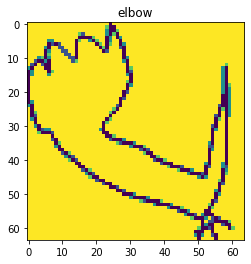

In [0]:
import io
b = next(images_and_labels_generator(32))
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

# Augmentation example

Using TensorFlow backend.


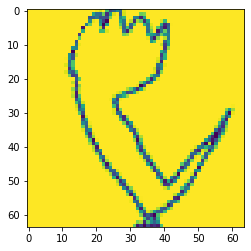

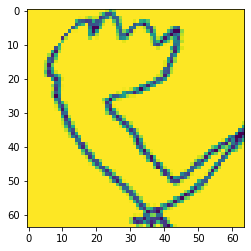

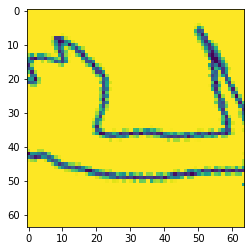

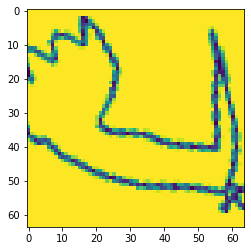

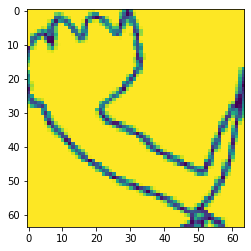

In [0]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    cval=255
)

image = b[0][10, :, :]

# add 3 channels to image
image = np.tile(np.expand_dims(image, axis=2), (1, 1, 3))

# 5 random augmentations
for _ in range(5):
    plt.imshow(image_gen.random_transform(image)[:, :, 0])
    plt.show()

# My augmenation

In [0]:
from scipy.ndimage import rotate
import random
from numba import njit

# как понял, нужно было написать минимум две функции аугментации

@njit
def add_noise(img, prob=0.01):
    output = np.zeros(img.shape, np.uint8)
    thres = 1 - prob 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = img[i][j]
    return output

def mirror(img):
    return np.fliplr(img)

def rotate(img, scale=1.1):
    angle = np.random.randint(10, 50)
    w = img.shape[1]
    h = img.shape[0]
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
    return cv2.warpAffine(img,M,(w,h))

def aug_images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_images.append(add_noise(draw_it(e[0])))
            batch_images.append(mirror(draw_it(e[0])))
            batch_images.append(rotate(draw_it(e[0])))
            for i in range(4):
                batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

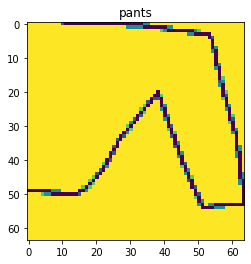

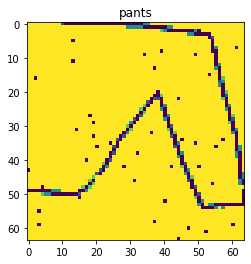

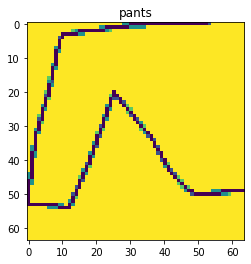

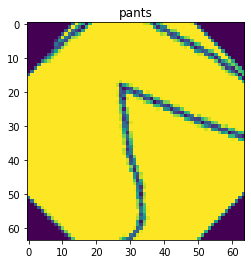

In [0]:
b = next(aug_images_and_labels_generator(32))
plt.imshow(b[0][0, :, :])
plt.title(b[1][0])
plt.show()

plt.imshow(b[0][1, :, :])
plt.title(b[1][1])
plt.show()

plt.imshow(b[0][2, :, :])
plt.title(b[1][2])
plt.show()

plt.imshow(b[0][3, :, :])
plt.title(b[1][3])
plt.show()

# Train simple network

In [0]:
import tensorflow as tf
import keras
from keras import backend as K

In [0]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
list(class_to_idx.items())[:5]

[('fence', 0), ('yoga', 1), ('horse', 2), ('sandwich', 3), ('cat', 4)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images / 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(list(map(class_to_idx.get, batch[1])), NUM_CLASSES)
        yield images, labels

In [0]:
sample = next(train_iterator(32))
print(sample[0].shape)
print(sample[1].shape)

(32, 64, 64, 1)
(32, 340)


In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, LeakyReLU

# Fisrt model public score 0.76192


In [0]:
def make_model():
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Dense(512, kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

In [0]:
# describe model
s = reset_tf_session()
model = make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)       

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 400
STEPS_PER_EPOCH = 400
EPOCHS = 10

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5., lr=0.0015),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
import os
GOOGLE_DRIVE_ROOT = GOOGLE_DRIVE_MOUNT + "/" + list(filter(lambda x: x[0] != '.', os.listdir(GOOGLE_DRIVE_MOUNT)))[0]
# print(GOOGLE_DRIVE_ROOT)

# will save checkpoints to Google Drive
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/model_{}"
# print(CHECKPOINT_TEMPLATE)

In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 8
# model = load_model(CHECKPOINT_TEMPLATE.format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

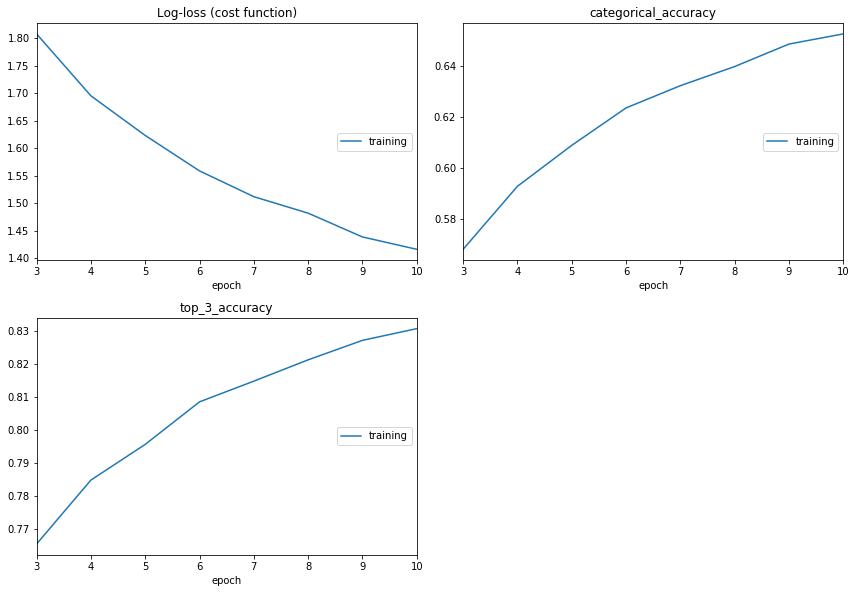

Log-loss (cost function):
training   (min:    1.416, max:    3.129, cur:    1.416)

categorical_accuracy:
training   (min:    0.328, max:    0.652, cur:    0.652)

top_3_accuracy:
training   (min:    0.510, max:    0.831, cur:    0.831)


In [0]:
# fit the model with our eternal generator!
from livelossplot import PlotLossesKeras

model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE), PlotLossesKeras()],
    verbose=1,
    initial_epoch=last_finished_epoch
)

# First aug model public score 0.75151



In [0]:
def first_make_model_aug():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    ### YOUR CODE HERE: replace with a better model! Batch normalization really helps!
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Dense(512, kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

In [0]:
s = reset_tf_session()
first_model_aug = first_make_model_aug()
first_model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)       

In [0]:
BATCH_SIZE = 400
STEPS_PER_EPOCH = 200
EPOCHS = 10

s = reset_tf_session() 
first_model_aug = first_make_model_aug()

first_model_aug.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5., lr=0.002),
    metrics=[categorical_accuracy, top_3_accuracy]
)

In [0]:
def train_iterator_aug(batch_size):
    for batch in aug_images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images / 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(list(map(class_to_idx.get, batch[1])), NUM_CLASSES)
        yield images, labels

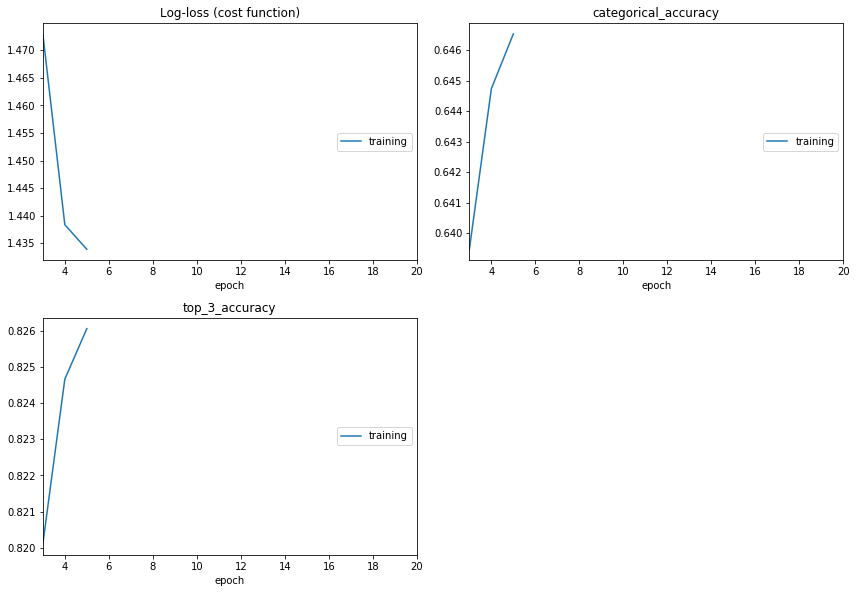

Log-loss (cost function):
training   (min:    1.434, max:    1.497, cur:    1.434)

categorical_accuracy:
training   (min:    0.633, max:    0.647, cur:    0.647)

top_3_accuracy:
training   (min:    0.816, max:    0.826, cur:    0.826)


In [0]:
EPOCHS = 20
last_finished_epoch = 15

first_model_aug.fit_generator(
    train_iterator_aug(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE), PlotLossesKeras()],
    verbose=1,
    initial_epoch=last_finished_epoch
)

# Second model public score 0.86223

In [0]:
IMG_SIZE = 128

def second_make_model():
    model = Sequential()

    model.add(Conv2D(8, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Dropout(0.1))
    
    model.add(Dense(512, kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

In [0]:
s = reset_tf_session()
second_model = second_make_model()
second_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 8)       80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)       

In [0]:
BATCH_SIZE = 400
STEPS_PER_EPOCH = 4000
EPOCHS = 20

s = reset_tf_session() 
second_model = second_make_model()

second_model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5., lr=0.0005),
    metrics=[categorical_accuracy, top_3_accuracy] 
)

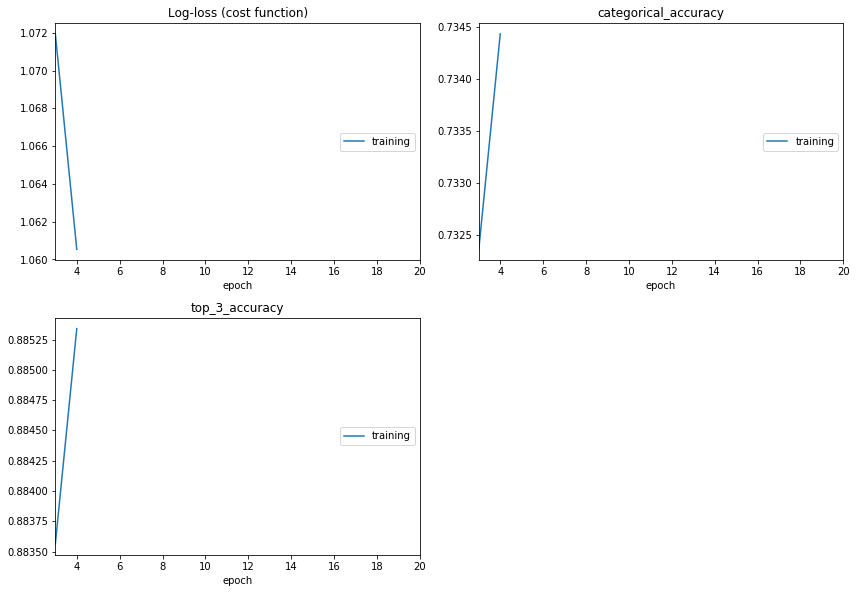

Log-loss (cost function):
training   (min:    1.061, max:    1.094, cur:    1.061)

categorical_accuracy:
training   (min:    0.727, max:    0.734, cur:    0.734)

top_3_accuracy:
training   (min:    0.881, max:    0.885, cur:    0.885)
Epoch 14/20
  32/4000 [..............................] - ETA: 16:56 - loss: 1.0725 - categorical_accuracy: 0.7329 - top_3_accuracy: 0.8830

KeyboardInterrupt: ignored

In [0]:
# EPOCHS = 20
last_finished_epoch = 9

second_model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE), PlotLossesKeras()],
    verbose=1,
    initial_epoch=last_finished_epoch
)

# Decrease learning rate public score 0.87492

In [0]:
from keras.models import load_model

last_finished_epoch = 12

s = reset_tf_session()
second_model_new_lr = second_make_model()

model = load_model(CHECKPOINT_TEMPLATE.format(last_finished_epoch), 
                   custom_objects={"top_3_accuracy": top_3_accuracy})

second_model_new_lr.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5., lr=0.00001),
    metrics=[categorical_accuracy, top_3_accuracy]
)

weights = model.get_weights()
second_model_new_lr.set_weights(weights)

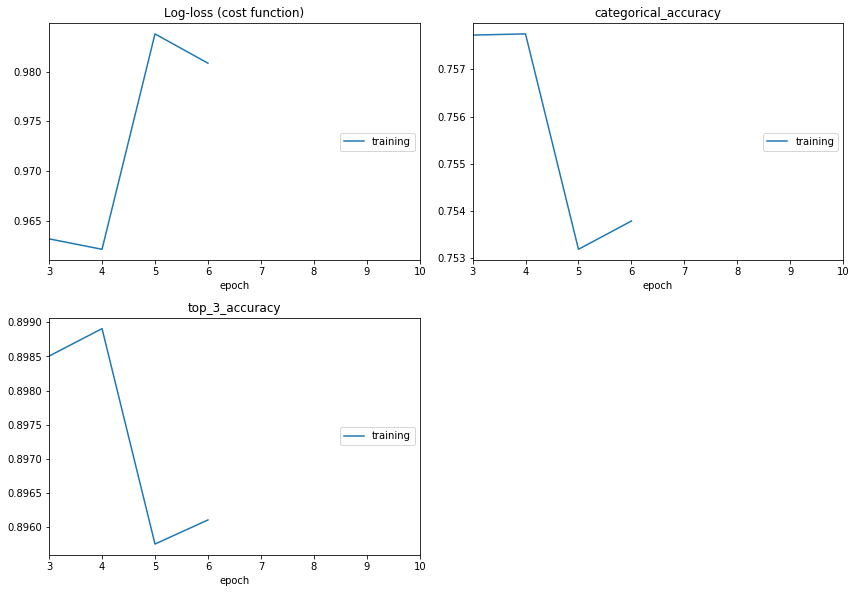

Log-loss (cost function):
training   (min:    0.962, max:    0.984, cur:    0.981)

categorical_accuracy:
training   (min:    0.753, max:    0.758, cur:    0.754)

top_3_accuracy:
training   (min:    0.896, max:    0.899, cur:    0.896)
Epoch 10/10
  79/4000 [..............................] - ETA: 16:45 - loss: 0.9607 - categorical_accuracy: 0.7599 - top_3_accuracy: 0.8982

KeyboardInterrupt: ignored

In [0]:
EPOCHS = 10
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/new_lr_model_{}"

second_model_new_lr.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE), PlotLossesKeras()],
    verbose=1,
    initial_epoch=3
)

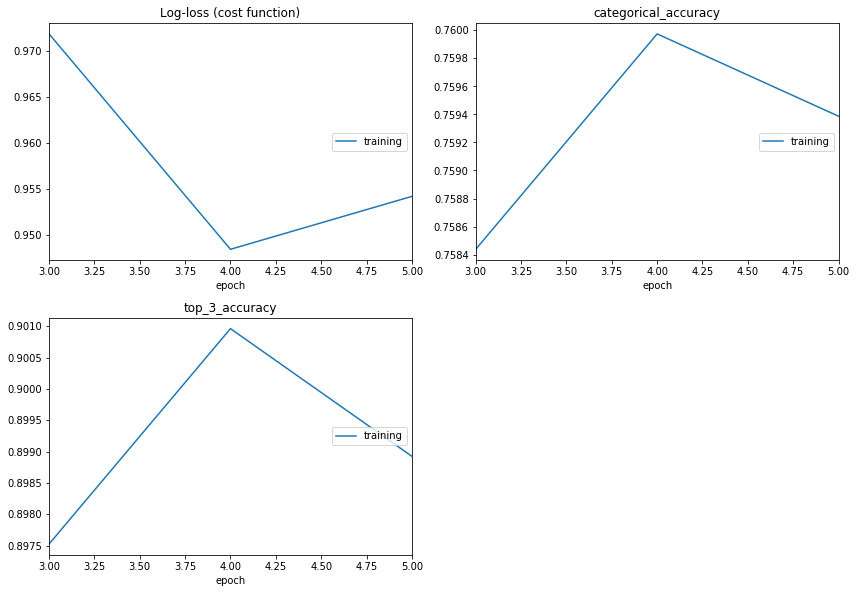

Log-loss (cost function):
training   (min:    0.948, max:    0.972, cur:    0.954)

categorical_accuracy:
training   (min:    0.756, max:    0.760, cur:    0.759)

top_3_accuracy:
training   (min:    0.898, max:    0.901, cur:    0.899)


In [0]:
last_finished_epoch = 3

s = reset_tf_session()
second_model_new_lr = second_make_model()

model = load_model(CHECKPOINT_TEMPLATE.format(last_finished_epoch), 
                   custom_objects={"top_3_accuracy": top_3_accuracy})

second_model_new_lr.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5., lr=0.000001),
    metrics=[categorical_accuracy, top_3_accuracy]
)

weights = model.get_weights()
second_model_new_lr.set_weights(weights)

EPOCHS = 5

second_model_new_lr.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=200,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE), PlotLossesKeras()],
    verbose=1,
    initial_epoch=0
)

In [0]:
second_model_new_lr = load_model(CHECKPOINT_TEMPLATE.format(3), 
                   custom_objects={"top_3_accuracy": top_3_accuracy})

# Score test set

In [0]:
# download test set
! KAGGLE_USERNAME=<user> KAGGLE_KEY=<token> kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

  0% 0.00/20.0M [00:00<?, ?B/s]
100% 20.0M/20.0M [00:00<00:00, 182MB/s]


In [0]:
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_it(line[2]))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                ### YOUR CODE HERE: normalize batch_images the same way as during training!
                batch_images = batch_images / 255 - 0.5

                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            ### YOUR CODE HERE: normalize batch_images the same way as during training!
            batch_images = batch_images / 255 - 0.5
            yield batch_keys, batch_images

In [0]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [0]:
with open("submission_2_decrease_lr3.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm_notebook(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        probas = second_model_new_lr.predict_proba(batch_images, BATCH_SIZE)
        top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
        labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
        for key, labels in zip(batch_keys, labels):
            f.write(key + "," + labels + "\n")

In [0]:
! wc -l submission.csv

112200 submission.csv


In [0]:
# submit to kaggle
! KAGGLE_USERNAME=<user> KAGGLE_KEY=<token> kaggle competitions submit quickdraw-doodle-recognition -f submission_2_decrease_lr3.csv -m "My precious second model decrease lr 3"

100% 4.41M/4.41M [00:04<00:00, 1.00MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge